<a href="https://colab.research.google.com/github/stemarzo/DISME/blob/main/02_Secondo_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRIMO ASSIGNMENT: CLASSIFICATORE SEGNALI AUDIO

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

##Esercitazione

###File Management

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

### Data Loader

Modulo il cui scopo è fornire iterativamnete al processo di training degli esempi, prendi i dati dalla cartella, estraggo la classe dal nome dei file e costrisce una matrice con da un lato il dato grezzo, mentre dall'altra parte mette la classe a cui appartiene il file.

In [ ]:
# Placecholder for feature extractor
#prede in input il dato delle varibili e lo restituisce così come è
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = [] #inizializza i due output che vogliamo estrarre
    features = []

    #ciclo che legge tutti i wav nella cartella, li legge, non interessa la frequenza per ora
    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)#segnale
            cur_features = feature_extractor(signal)#feature extractor e le aggiungo a feature
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]# prendo solo la prima parte del nome del file
            labels.append(label)

    # divido i dati di training 90% e test 10%
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)# random state, è un random seed praticamente

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)#converto in array il training
        X_train_mean = X_train.mean(axis=0)#calcolo media e std per ogni colonna
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)# impongo media 0 e std 1
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

noi non andremo ad eleborare le informazioni grezze, ma andreamo a costruire dei feature extractor.

i classificatori vogliono che tutti gli input abbiano la stessa lunghezza

### Addestramento con Crop

In [ ]:
def crop(input, size=100):
  output = input[0:min(input.shape[0], 100)]
  output = np.concatenate((output, np.zeros(size-output.shape[0])))
  return output

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=crop)

In [ ]:
len(X_train) #90% di 1500

1350

In [ ]:
X_train[0].shape #cento valori perche fatto col crop

(100,)

utilizziamo una svm per addestrare, usiamo svc come funzione, specifichiamo la funzione con kernel, quella scelta da noi è un'estensione del k-nearest neighborhood, nel nostro caso le classi sono già bilanciate, quindi buona

In [ ]:
# Addestramento classificatore
clf = SVC(kernel = 'rbf', class_weight='balanced')# inizializzato la SMV
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test) #previsioni

In [ ]:
print(classification_report(y_test, y_pred)) # statistiche

              precision    recall  f1-score   support

           0       0.12      0.06      0.08        17
           1       0.27      0.30      0.29        10
           2       0.00      0.00      0.00        15
           3       0.27      0.16      0.20        19
           4       0.29      0.36      0.32        11
           5       0.00      0.00      0.00        14
           6       0.15      1.00      0.26        14
           7       0.00      0.00      0.00        19
           8       0.50      0.06      0.11        17
           9       0.33      0.07      0.12        14

    accuracy                           0.18       150
   macro avg       0.19      0.20      0.14       150
weighted avg       0.19      0.18      0.12       150



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 1  3  0  2  0  0  9  1  0  1]
 [ 2  3  1  0  0  0  4  0  0  0]
 [ 0  0  0  1  2  0 11  0  1  0]
 [ 0  0  0  3  1  0 14  1  0  0]
 [ 0  1  0  1  4  2  3  0  0  0]
 [ 0  1  0  2  1  0  9  0  0  1]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  1  0  0  1  0 17  0  0  0]
 [ 2  0  0  2  5  1  6  0  1  0]
 [ 3  2  1  0  0  0  7  0  0  1]]


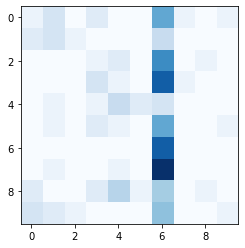

In [ ]:
plt.imshow(cm, cmap=plt.cm.Blues) #a colpo d'occhio matrice di confusione

### Addestramento con SDEV

la lunghezza delle feature è 1 in questa occasione

In [ ]:
def sdev(input):
  output = np.std(input, keepdims=True)
  #print(output)
  return output
# il classificatore di SVM, come feature di input, non accettano degli scalari,
# vogliono che ciascun esmpio del training sia un vettore, quindi keepdims mantiene
# l'output di tipo vettoriale

In [ ]:
X_train_sdev, X_test_sdev, y_train_sdev, y_test_sdev = load_data(feature_extractor=sdev)

In [ ]:
clf_sdev = SVC(kernel = 'rbf', class_weight='balanced')# inizializzato la SMV
clf_sdev = clf.fit(X_train_sdev, y_train_sdev)

In [ ]:
y_pred_sdev = clf.predict(X_test_sdev) #previsioni

In [ ]:
print(classification_report(y_test_sdev, y_pred_sdev)) # statistiche

              precision    recall  f1-score   support

           0       0.29      0.12      0.17        17
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           3       0.27      0.21      0.24        19
           4       0.13      0.27      0.18        11
           5       0.10      0.21      0.14        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        19
           8       0.04      0.12      0.06        17
           9       0.16      0.29      0.21        14

    accuracy                           0.12       150
   macro avg       0.10      0.12      0.10       150
weighted avg       0.11      0.12      0.10       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm_sdev = confusion_matrix(y_test_sdev, y_pred_sdev)
print(cm_sdev)

[[2 0 0 0 3 0 0 2 7 3]
 [0 0 0 2 2 2 0 0 4 0]
 [0 0 0 2 1 5 0 1 3 3]
 [0 0 0 4 3 3 0 0 7 2]
 [3 0 0 0 3 1 0 0 1 3]
 [1 1 0 1 1 3 0 0 5 2]
 [0 0 0 1 4 1 0 0 7 1]
 [0 0 0 1 1 6 0 0 8 3]
 [1 0 0 2 4 4 0 0 2 4]
 [0 0 0 2 1 4 0 0 3 4]]


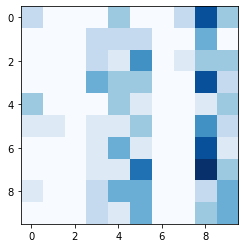

In [ ]:
plt.imshow(cm_sdev, cmap=plt.cm.Blues) #a colpo d'occhio matrice di confusione

### Addestramento CROP + SDEV

In [ ]:
def combo(input):
  return np.concatenate((crop(input), sdev(input)))

In [ ]:
X_train_combo, X_test_combo, y_train_combo, y_test_combo = load_data(feature_extractor=combo)

In [ ]:
# Addestramento classificatore
clf_combo = SVC(kernel = 'rbf', class_weight='balanced')# inizializzato la SMV
clf_combo = clf.fit(X_train_combo, y_train_combo)

In [ ]:
y_pred_combo = clf_combo.predict(X_test_combo) #previsioni

In [ ]:
print(classification_report(y_test_combo, y_pred_combo)) # statistiche

              precision    recall  f1-score   support

           0       0.29      0.12      0.17        17
           1       0.27      0.30      0.29        10
           2       1.00      0.13      0.24        15
           3       0.30      0.16      0.21        19
           4       0.23      0.27      0.25        11
           5       0.00      0.00      0.00        14
           6       0.18      0.29      0.22        14
           7       0.17      0.68      0.27        19
           8       0.50      0.06      0.11        17
           9       0.25      0.07      0.11        14

    accuracy                           0.21       150
   macro avg       0.32      0.21      0.19       150
weighted avg       0.32      0.21      0.18       150



In [ ]:
cm_combo = confusion_matrix(y_test_combo, y_pred_combo)
print(cm_combo)

[[ 2  3  0  1  0  0  2  9  0  0]
 [ 1  3  0  0  0  0  0  5  0  1]
 [ 0  0  2  1  2  0  2  7  1  0]
 [ 0  0  0  3  1  0  3 12  0  0]
 [ 1  1  0  1  3  2  2  1  0  0]
 [ 0  1  0  2  1  0  3  6  0  1]
 [ 0  0  0  0  0  0  4 10  0  0]
 [ 0  0  0  0  1  0  5 13  0  0]
 [ 1  0  0  2  5  1  0  6  1  1]
 [ 2  3  0  0  0  0  1  7  0  1]]


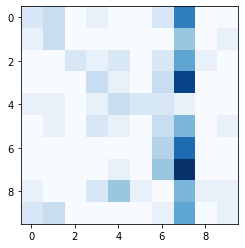

In [ ]:
plt.imshow(cm_combo, cmap=plt.cm.Blues) #a colpo d'occhio matrice di confusione

### Addestramento Combo + Normalizzazione

In [ ]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = load_data(feature_extractor=combo, normalize=True)

In [ ]:
# Addestramento classificatore
clf_norm = SVC(kernel = 'rbf', class_weight='balanced')# inizializzato la SMV
clf_norm = clf.fit(X_train_norm, y_train_norm)

In [ ]:
y_pred_norm = clf_norm.predict(X_test_norm) #previsioni

In [ ]:
print(classification_report(y_test_norm, y_pred_norm)) # statistiche

              precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.38      0.30      0.33        10
           2       0.80      0.27      0.40        15
           3       0.50      0.21      0.30        19
           4       0.29      0.36      0.32        11
           5       0.00      0.00      0.00        14
           6       0.19      0.36      0.25        14
           7       0.16      0.63      0.26        19
           8       1.00      0.06      0.11        17
           9       0.33      0.07      0.12        14

    accuracy                           0.25       150
   macro avg       0.41      0.25      0.24       150
weighted avg       0.42      0.25      0.24       150



### Cercare i giusti parametri

metaclassificatore per trovare i parametri corretti.

Usiamo una griglia di parametri C e gamma

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

con grid search cv, divide il train in train e validation e li usa per addestrare e validare i parametri della griglia per trovare i migliori.

In [ ]:
param_grid = {
    'C': [100,500,1000],
    'gamma': [0.005, 0.01,0.1,0.5,1.0]
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

clf = clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_.C

500

In [ ]:
clf.best_estimator_.gamma

0.1

In [ ]:
y_pred = clf.predict(X_test) #prevision

In [ ]:
print(classification_report(y_test, y_pred)) # statistiche

              precision    recall  f1-score   support

           0       0.62      0.59      0.61        17
           1       0.41      0.70      0.52        10
           2       0.22      0.67      0.33        15
           3       0.62      0.26      0.37        19
           4       0.20      0.18      0.19        11
           5       0.33      0.07      0.12        14
           6       0.33      0.50      0.40        14
           7       0.13      0.11      0.12        19
           8       0.11      0.06      0.08        17
           9       0.60      0.21      0.32        14

    accuracy                           0.32       150
   macro avg       0.36      0.33      0.30       150
weighted avg       0.36      0.32      0.30       150



### Addestramento con MFCC

In [ ]:
def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Sample values
    signal = input[::sampling]
    # Compute MFCC coefficients
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Flatten into monodimensional vector for the SVM
    mfcc = mfcc.flatten()
    return mfcc



In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=mfcc, normalize=True)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2007
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1976
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1987
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

In [ ]:
param_grid = {
    'C': [100,500,1000],
    'gamma': [0.005, 0.01,0.1,0.5,1.0]
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test) #previsioni

In [ ]:
print(classification_report(y_test, y_pred)) # statistiche

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      0.93      0.96        14
           6       0.82      1.00      0.90        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      0.93      0.96        14

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



## Assignment


**Consegna:** Implementare un feature extraction basato su Zero Cossing Rate:
[10 14 5 -5 -7 10] --> ZCR=2 

*   Voce elenco
*   Voce elenco


Passaggio da positivo a negativo
traslare i dati di una posizione valutare i segni dei due vettori

**Implementazione**: vengono confrontati i segni dei valori appartenti al segnale (posizione corrente) con quelli del segnale traslato di una posizione (posizione successiva), creando un'array contente i valori:

*   0 --> se i segni dei valori sono gli stessi
*   1 --> se i segni dei valori sono diversi, c'è un cambio di segno

Avremo quindi un array contente il valore 1 per ogni cambio di segno, successivamente sommando tutti i valori 1 si ottiene la feature richiesta.



In [ ]:
def zero_cross(input):
  input=input[input != 0]
  sign = np.array(np.where(np.sign(input)*np.sign(np.roll(input, -1)) < 0, 1, 0))
  output = np.sum(sign, keepdims=True)
  return output

In [ ]:
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr = load_data(feature_extractor=zero_cross)

In [ ]:
len(X_train_zcr)

1350

Con le feature estratte dal segnale viene utilizzata una SVM (come già applicato in precedenza) per la classificazione dei diversi segnali.

In [ ]:
param_grid = {
    'C': [100,500,1000],
    'gamma': [0.005, 0.01,0.1,0.5,1.0]
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

clf = clf.fit(X_train_zcr, y_train_zcr)

In [ ]:
y_pred_zcr = clf.predict(X_test_zcr) 

Vengono mostrate le performance del classificatore, come si può notare sono molto scarse con un'accuracy del 23%

In [ ]:
print(classification_report(y_test_zcr, y_pred_zcr)) 

              precision    recall  f1-score   support

           0       0.45      0.29      0.36        17
           1       0.13      0.40      0.20        10
           2       0.17      0.13      0.15        15
           3       0.27      0.21      0.24        19
           4       0.08      0.09      0.08        11
           5       0.16      0.21      0.18        14
           6       0.64      0.64      0.64        14
           7       0.00      0.00      0.00        19
           8       0.25      0.18      0.21        17
           9       0.31      0.29      0.30        14

    accuracy                           0.23       150
   macro avg       0.25      0.24      0.23       150
weighted avg       0.25      0.23      0.23       150

